In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [8]:
from langchain.tools import tool

### This is my custom tool

In [9]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers.
    
    Args:
        a (int): The first number.
        b (int): The second number.
        
        Returns:
        int: The product of a and b."""
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds two numbers.

    Args:
        a (int): The first number.
        b (int): The second number.

    Returns:
        int: The sum of a and b."""
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divides two numbers.

    Args:
        a (int): The numerator.
        b (int): The denominator.

    Returns:
        float: The result of the division.
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

### Importing the inbuilt tool

In [10]:
from langchain_community.tools import DuckDuckGoSearchResults
search = DuckDuckGoSearchResults()

In [7]:
search.invoke("What is the latest update on iPhone 17 release?")

'snippet: iPhone 17: Price. We haven\'t yet heard if the iPhone 17 line will cost the same as the iPhone 16 line. Most rumors suggest the "Plus" model will be replaced by the new super-slim "Air ..., title: iPhone 17: Release date, rumors, specs, price of Apple\'s 2025 iPhone ..., link: https://www.macworld.com/article/2393967/iphone-17-release-date-specs-features-rumors.html, snippet: 2025 could bring one of the biggest updates to the iPhone\'s design that we\'ve seen since the 2017 iPhone X, with Apple rumored to be planning for an all-new iPhone 17 "Air" that has a much thinner ..., title: iPhone 17: Everything We Know - MacRumors, link: https://www.macrumors.com/roundup/iphone-17/, snippet: The iPhone 17 is already shaping up to be one of its biggest updates in years. From the ultra-slim iPhone 17 Air to a new matte finish, upgraded front cameras, a possible sky blue model and more ..., title: iPhone 17: Everything to know, from release date to price, link: https://www.independent.

In [11]:
tools = [multiply, add, divide, search]

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [20]:
response = llm_with_tools.invoke("what is 10/2")

In [21]:
response.content

''

In [22]:
response.tool_calls

[{'name': 'divide',
  'args': {'a': 10, 'b': 2},
  'id': 'vr6aned0b',
  'type': 'tool_call'}]

In [23]:
response = llm_with_tools.invoke("what is the current age of the TATA group?")

In [24]:
response.content

''

In [25]:
response.tool_calls

[{'name': 'duckduckgo_results_json',
  'args': {'query': 'TATA group age 2023'},
  'id': '67zzrwrny',
  'type': 'tool_call'}]

In [56]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."

In [54]:
user_query=["tell me what is 2+2"]

In [55]:
[SYSTEM_PROMPT]+user_query

['You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.',
 'tell me what is 2+2']

In [58]:
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [99]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph,MessagesState,START,END

In [60]:
builder = StateGraph(MessagesState)

In [61]:
builder.add_node("llm_decision_step",function_1)

In [46]:
tools

[StructuredTool(name='multiply', description='Multiplies two numbers.\n\nArgs:\n    a (int): The first number.\n    b (int): The second number.\n\n    Returns:\n    int: The product of a and b.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000024A7FE34900>),
 StructuredTool(name='add', description='Adds two numbers.\n\nArgs:\n    a (int): The first number.\n    b (int): The second number.\n\nReturns:\n    int: The sum of a and b.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000024A7FE34680>),
 StructuredTool(name='divide', description='Divides two numbers.\n\nArgs:\n    a (int): The numerator.\n    b (int): The denominator.\n\nReturns:\n    float: The result of the division.', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x0000024A7FE347C0>),
 DuckDuckGoSearchResults(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_res

In [62]:
from langgraph.prebuilt import ToolNode
builder.add_node("tools", ToolNode(tools))

In [63]:
builder.add_edge(START, "llm_decision_step")

In [64]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges("llm_decision_step", tools_condition)


In [65]:
builder.add_edge("tools","llm_decision_step")

In [66]:
react_graph = builder.compile()

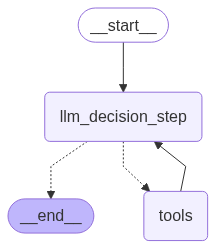

In [67]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [68]:
message=[HumanMessage(content="What is 2 times of narendramodi's age?")]

In [69]:
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='1d11efac-14e5-4dd3-b8ee-af06a5c9887e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v617a7ahf', 'function': {'arguments': '{"query":"Narendra Modi age 2023"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 386, 'prompt_tokens': 420, 'total_tokens': 806, 'completion_time': 1.5439639189999999, 'prompt_time': 0.034701109, 'queue_time': 0.20360367199999999, 'total_time': 1.578665028}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2916dcde-342a-4916-938f-c866aa1c0183-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'Narendra Modi age 2023'}, 'id': 'v617a7ahf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 420, 'output_tokens': 386, 'total_tokens': 806}

In [74]:
message = [HumanMessage(content="How much is the net worth of Elon Musk, and divide it by 2?")]

In [75]:
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content='How much is the net worth of Elon Musk, and divide it by 2?', additional_kwargs={}, response_metadata={}, id='0e5082ff-9104-4b34-900e-fd76be47f696'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ddsbz5eea', 'function': {'arguments': '{"query":"Elon Musk net worth 2023"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 244, 'prompt_tokens': 424, 'total_tokens': 668, 'completion_time': 0.887272727, 'prompt_time': 0.029349208, 'queue_time': 0.210025413, 'total_time': 0.916621935}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4b31d069-a369-4bfb-8fa2-126e0f82f9f5-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'Elon Musk net worth 2023'}, 'id': 'ddsbz5eea', 'type': 'tool_call'}], usage_metadata={'input_tokens': 424, 'output_tokens': 244, 'total_tok

In [82]:
message = [HumanMessage(content="What is the speed of light in m/s and multiply it by 10?")]

In [83]:
response=react_graph.invoke({"messages":message})

In [84]:
response["messages"][-1].content

'The speed of light is 299,792,458 meters per second. When multiplied by 10, the result is 2,997,924,580 meters per second.'

In [85]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (1wh5xryf5)
 Call ID: 1wh5xryf5
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: multiply

2997924580
================================== Ai Message ==================================

The speed of light is 299,792,458 meters per second. When multiplied by 10, the result is 2,997,924,580 meters per second.


In [87]:
import yfinance as yf

In [88]:
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

In [89]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $199.20.'

In [90]:
get_stock_price.invoke("TSLA")

'The last closing price of TSLA was $319.11.'

In [93]:
tools

[StructuredTool(name='add', description='Adds two numbers.\n\nArgs:\n    a (int): The first number.\n    b (int): The second number.\n\nReturns:\n    int: The sum of a and b.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000024A7FE34680>),
 StructuredTool(name='multiply', description='Multiplies two numbers.\n\nArgs:\n    a (int): The first number.\n    b (int): The second number.\n\n    Returns:\n    int: The product of a and b.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000024A7FE34900>),
 StructuredTool(name='divide', description='Divides two numbers.\n\nArgs:\n    a (int): The numerator.\n    b (int): The denominator.\n\nReturns:\n    float: The result of the division.', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x0000024A7FE347C0>),
 DuckDuckGoSearchResults(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_res

In [92]:
tools = [add, multiply, divide, search, get_stock_price]

In [94]:
llm_with_tools=llm.bind_tools(tools)

In [95]:
response=llm_with_tools.invoke("can you give me a latest stock price of adani greens?")

In [96]:
response.content

''

In [97]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.BO'},
  'id': 'fy7nk9svd',
  'type': 'tool_call'}]

In [100]:
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [101]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_step", function_1)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools", "llm_decision_step")
react_graph2 = workflow.compile()

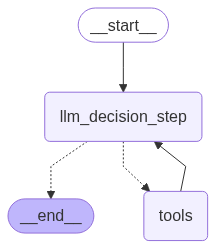

In [102]:
display(Image(react_graph2.get_graph(xray=True).draw_mermaid_png()))

In [105]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [106]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (4mp2ngqmx)
 Call ID: 4mp2ngqmx
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================
Tool Calls:
  add (nkrvx1w1w)
 Call ID: nkrvx1w1w
  Args:
    a: 199
    b: 1000
================================= Tool Message =================================
Name: add

1199
================================== Ai Message ==================================

The result of adding 1000 to the current stock price of Apple is 1199.


In [118]:
messages = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [119]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you give me 2 times of current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (q5b84gxtr)
 Call ID: q5b84gxtr
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $199.20.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (8gatyw6qe)
 Call ID: 8gatyw6qe
  Args:
    query: latest news Apple
================================= Tool Message =================================
Name: duckduckgo_results_json

snippet: At today's WWDC 2025 keynote event, Apple unveiled a new design that will inform the next decade of iOS, iPadOS, and macOS development, so needless to say, it was a busy day. Apple also unveiled a ..., 